## Plot three-panel CFAD plot
- lapse rate CFAD with mean lapse rate and mean relative humidity (from radiosondes)
- reflectivity CFAD from W-band radar
- reflectivity CFAD from SEA-POL QVP

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns
#import cmweather
import cmocean

from orcestra_read_data import *
from thermo_functions import *

Define functions and colormaps

In [2]:
def compute_cfad(invar, bins):
    nz = invar.shape[1]
    nbin = len(bins)
    hist_density=np.zeros((nbin-1,nz))
    for iz in range(nz):
        count, bin_edges = np.histogram(invar[:,iz], bins=bins, density=True)
        hist_density[:,iz] = count
    return hist_density, bin_edges

In [3]:
# Vertical smoothing function
def vert_smooth(invar, nz_smooth=10):
    invar_pd = pd.DataFrame(invar)
    invar_pd = (invar_pd.transpose()).rolling(window=nz_smooth, center=True, closed='both', min_periods=3).mean()
    return np.squeeze(np.array(invar_pd).transpose())

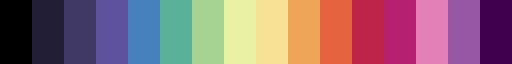

In [4]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='white') #set missing (NaN) values to white
discrete_mask_cmap

# Radiosondes

Read in data

In [5]:
#CID: bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4
#root_radio = 'ipns://latest.orcestra-campaign.org/products/Radiosondes/Level_2'
#dset_radio = xr.open_dataset(f"{root_radio}/RAPSODI_RS_ORCESTRA_level2.zarr",engine="zarr")
dset_radio = xr.open_dataset(f"ipfs://bafybeid7cnw62zmzfgxcvc6q6fa267a7ivk2wcchbmkoyk4kdi5z2yj2w4", engine="zarr")
snd_asc = read_soundings(platform='RV_Meteor', ascent=0) #Read ascending soundings

# Mask soundings that don't reach 100 hPa
snd_asc, min_pres = mask_soundings(snd_asc, p_threshold=100)

times_asc = snd_asc['times']
hght = snd_asc['hght']

Calculate

In [6]:
# Static stability
theta = theta_dry(snd_asc['tmpk'], snd_asc['p'])
theta = vert_smooth(theta, nz_smooth=10)
dthdz = np.gradient(theta, hght, axis=1) # K/m
dthdz = vert_smooth(dthdz, nz_smooth=10)

In [7]:
# CFAD of lapse rate
nbin=50
fmin=-2
fmax=16
step=(fmax-fmin)/nbin
bins_lapserate=np.arange(fmin,fmax,step)

cfad_density_lapserate, bin_edges_lapserate = compute_cfad(dthdz*1e3, bins_lapserate) #K/km

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [8]:
# Means
mean_lapserate = np.nanmean(dthdz*1e3, axis=0)

rh_asc = calc_relh(snd_asc['mr'], snd_asc['p'], snd_asc['tmpk'], ice=True)
mean_rh = np.nanmean(rh_asc, axis=0)

mean_freezinglevel = np.nanmean(snd_asc['hght_0c'])

/tmp/ipykernel_1346884/364740152.py:2: RuntimeWarning: Mean of empty slice
  mean_lapserate = np.nanmean(dthdz*1e3, axis=0)


# W-band cloud radar

Read in data

In [9]:
start_time = np.datetime64('2024-08-16T10:10:00')
end_time = np.datetime64('2024-09-23T22:50:00')

#Make days array
days = np.arange(start_time, end_time, np.timedelta64(1, 'D'))
#convert days to YYYY-MM-DD format
days = [pd.to_datetime(str(day)).strftime('%Y-%m-%d') for day in days]

# Time increment to interpolate to
time_increment = 1 #in minutes

In [10]:
# Read in data
#QmSw6jc9FrcY6tcnKw2bvHJ2NYwS5WwRjSsPxNM4fcVvTr
#wband = xr.open_dataset("ipfs://bafybeiceihwds4qy6nqxfpp7qqot7xjlpjrtv5yq3t6uwnupk3bawhnbte", engine="zarr")
wband_all = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
wband_all

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloud radar and Cloudnet on RV Meteor during BOWTIE
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

In [11]:
# Exclude data with rain attenuation
wband = wband_all.Z[wband_all.rain_attenuation_flag!=1]
wband

<xarray.DataArray 'Z' (time: 103079, height: 393)> Size: 162MB
[40510047 values with dtype=float32]
Coordinates:
  * height   (height) float32 2kB 120.3 135.3 150.2 ... 1.194e+04 1.198e+04
  * time     (time) datetime64[ns] 825kB 2024-08-17T00:00:15 ... 2024-09-22T2...
Attributes:
    units:                dBZ
    source:               RPG-Radiometer Physics RPG-FMCW-94
    long_name:            Radar reflectivity factor
    comment:              This variable has been corrected for attenuation by...
    ancillary_variables:  Z_error Z_bias Z_sensitivity

In [12]:
# Interpolate to X-minutes
#times_Xmin = np.arange(wband.time.values[0], wband.time.values[-1], np.timedelta64(time_increment, 'm'))
#wband_Xmin = wband.interp(time=times_Xmin)

# OR DON'T
wband_Xmin = wband

height = wband_Xmin.height.values


Calculate

In [13]:
# CFAD of w-band reflectivity

nbin = 130
fmin = -70
fmax = 61
bins_wband = np.linspace(fmin,fmax,nbin+1)

#cfad_density_wband_old, bin_edges_wband = compute_cfad(wband_Xmin_old.Ze_interpolated.values, bins_wband)
#cfad_density_wband, bin_edges_wband = compute_cfad(wband_Xmin.Z.values, bins_wband)
cfad_density_wband, bin_edges_wband = compute_cfad(wband_Xmin.values, bins_wband) #rain attenuation filtered

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


# SEA-POL QVP

Read in data

In [14]:
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4a/qvp_1d/PICCOLO_gridded_qvp_1d.nc')
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_qvp_1D.nc')
#qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4/PICCOLO_level4_qvp_1D.nc')
qvp = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.2/PICCOLO_level4_qvp_1D.nc')

Calculate

In [15]:
# CFAD of sea-pol reflectivity

nbin = 130
fmin = -70
fmax = 61
bins_qvp = np.linspace(fmin,fmax,nbin+1)

cfad_density_qvp, bin_edges_qvp = compute_cfad(qvp.DBZ, bins_qvp)

/home/awing/.conda/envs/orcestra/lib/python3.13/site-packages/numpy/lib/_histograms_impl.py:901: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


# Plot

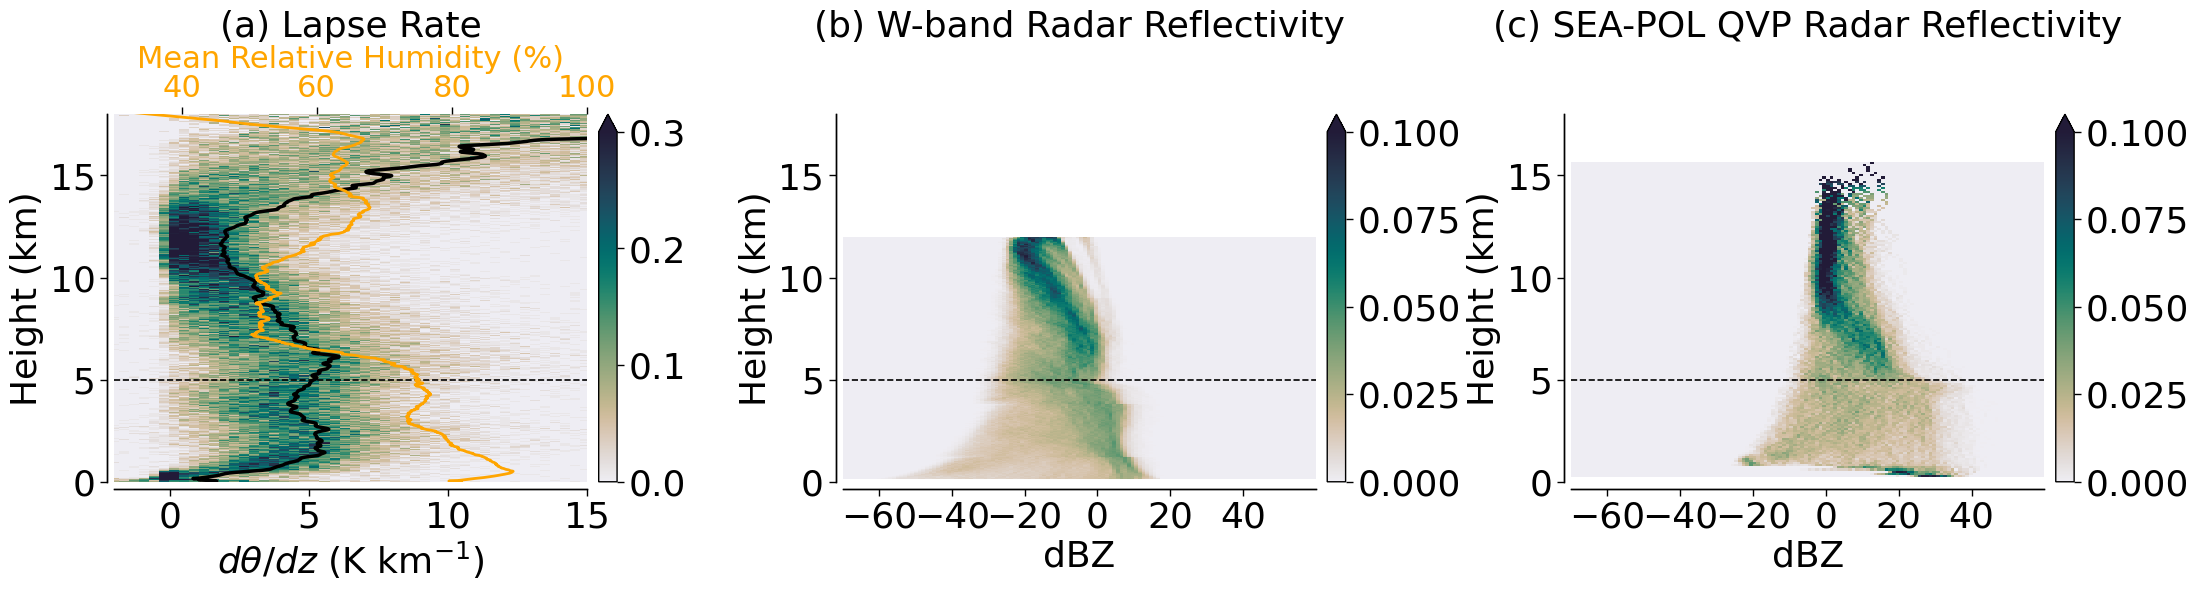

In [17]:
fig,axs = plt.subplots(1,3,figsize=(22,6))

#########################################################
### Lapse rate CFAD
#########################################################
cfad = axs[0].pcolormesh(bins_lapserate[:-1],hght/1000,cfad_density_lapserate.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.3),shading='nearest')
axs[0].plot(mean_lapserate, hght/1000, color='black', linewidth=2.5, label='Mean')

#plot a horizontal line at the freezing level
axs[0].axhline(mean_freezinglevel/1000, color='black', linestyle='--', label='Mean freezing level')


cbar=plt.colorbar(cfad,location='right',orientation='vertical', extend='max',pad=0.02)
cbar.ax.tick_params(labelsize=26)

axs[0].set_xlim(-2,15)
axs[0].set_ylim(0,18)
axs[0].set_title('(a) Lapse Rate',fontsize=26)
axs[0].set_ylabel('Height (km)', fontsize=26)
axs[0].set_xlabel(r'$d\theta/dz$ (K km$^{-1}$)',fontsize=26)
axs[0].tick_params(axis='both', labelsize=26)

twiny = axs[0].twiny()
twiny.plot(mean_rh, hght/1000, '-', color='orange', linewidth=2)
twiny.set_xlabel('Mean Relative Humidity (%)', fontsize=22, color='orange')
twiny.set_xlim(30, 100)
#twiny.set_xticklabels(twiny.get_xticklabels(), fontsize=14, color='orange')
twiny.tick_params(axis='x',labelsize=22, color='black',labelcolor='orange')

#########################################################
### W-band CFAD
#########################################################
cfad = axs[1].pcolormesh(bins_wband[:-1],height/1000,cfad_density_wband.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.1),shading='nearest')

#plot a horizontal line at the freezing level
axs[1].axhline(mean_freezinglevel/1000, color='black', linestyle='--', label='Mean freezing level')

cbar1=plt.colorbar(cfad,location='right',orientation='vertical', extend='max', pad=0.02)
cbar1.ax.tick_params(labelsize=26)

axs[1].set_xlim(-70,60)
axs[1].set_ylim(0,18)
axs[1].set_title('(b) W-band Radar Reflectivity',fontsize=26)
axs[1].set_ylabel('Height (km)', fontsize=26)
axs[1].set_xlabel('dBZ',fontsize=26)
axs[1].set_xticks([-60, -40, -20,0, 20, 40])
axs[1].tick_params(axis='both', labelsize=26)

#hack to get consistent title spacing
twiny = axs[1].twiny()
twiny.set_xlabel('test',fontsize=22, color='white')
#twiny.set_xticklabels(twiny.get_xticklabels(), fontsize=14, color='white')
twiny.tick_params(axis='x',labelsize=22,color='white',labelcolor='white')

#########################################################
### SEA-POL QVP CFAD
#########################################################
cfad = axs[2].pcolormesh(bins_qvp[:-1],qvp.Z/1000,cfad_density_qvp.transpose(),cmap=cmocean.cm.rain,norm=colors.Normalize(vmin=0,vmax=0.1),shading='nearest')  

#plot a horizontal line at the freezing level
axs[2].axhline(mean_freezinglevel/1000, color='black', linestyle='--', label='Mean freezing level')

cbar2=plt.colorbar(cfad,location='right',orientation='vertical', extend='max',pad=0.02)
cbar2.ax.tick_params(labelsize=26)

axs[2].set_xlim(-70,60)
axs[2].set_ylim(0,18)
axs[2].set_title('(c) SEA-POL QVP Radar Reflectivity',fontsize=26)
axs[2].set_ylabel('Height (km)', fontsize=26)
axs[2].set_xlabel('dBZ',fontsize=26)
axs[2].set_xticks([-60, -40, -20,0, 20, 40])
axs[2].tick_params(axis='both', labelsize=26)

#hack to get consistent title spacing
twiny = axs[2].twiny()
twiny.set_xlabel('test',fontsize=22, color='white')
#twiny.set_xticklabels(twiny.get_xticklabels(), fontsize=14, color='white')
twiny.tick_params(axis='both', labelsize=22, color='white',labelcolor='white')

sns.set_context('paper') 
sns.despine(offset=5)
sns.despine(ax=cbar.ax, left=True, bottom=True, right=True, top=True)
sns.despine(ax=cbar1.ax, left=True, bottom=True, right=True, top=True)
sns.despine(ax=cbar2.ax, left=True, bottom=True, right=True, top=True)
plt.tight_layout() 

## Save plot
plt.savefig('../../figures/Fig_CFAD.png', bbox_inches='tight', dpi=300)